# 2021/12/06

In [18]:
import pandas as pd
import numpy as np
import sys, os
import argparse
from datetime import datetime
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold, PredefinedSplit
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score

input_path='/pod/2/li-lab/Ziwei/Nanopore/daily/test/total.test.bed.gz'

In [15]:
if input_path.endswith(".gz"):
    df=pd.read_csv(input_path, compression='gzip', sep='\t')


#Splitting the data into independent and dependent variables
df_feature = df.loc[:,['5hmC_prob','5mC_prob']].values
df_class = df.loc[:,['label']].values
df_class = np.squeeze(df_class) #Convert the label into 1d-array

X = df_feature
y = df_class
    
    ########Split the dataset
    #Split the data into training:validation:testing = 8:1:1
X_train, X_tmp, y_train, y_tmp = train_test_split(X,
                                                      y,
                                                      train_size=0.8,
                                                      stratify=y,
                                                      random_state=42)

    #Split the data into training and testing
X_test, X_val, y_test, y_val = train_test_split(X_tmp,
                                                    y_tmp,
                                                    train_size=0.5,
                                                    stratify=y_tmp,
                                                    random_state=42)
    
print("Before the pipeline:\n y_train:{},\n y_val:{},\n y_test: {}".format(Counter(y_train), Counter(y_val), Counter(y_test)))
    
    ######## Downsampling
    ####Testing
n = np.bincount(y_test)[-1]
key=[0,1,2]
value = [(n, n, n)] ###Set up the ratio: 1:1:1
for i in value:
    sampling_strategy = dict(zip(key, i)).copy()

sampler = RandomUnderSampler(random_state = 42, sampling_strategy=sampling_strategy)
X_test_res, y_test_res = sampler.fit_resample(X_test, y_test)
print("Before downsampling: y_test: {},\nAfter downsampling:y_test_res: {}".format(Counter(y_test), Counter(y_test_res)))
    
    ####Validation
n = np.bincount(y_val)[-1]
key=[0,1,2]
value = [(n, n, n)] ###Set up the ratio: 1:1:1
for i in value:
    sampling_strategy = dict(zip(key, i)).copy()

sampler = RandomUnderSampler(random_state = 42, sampling_strategy=sampling_strategy)
X_val_res, y_val_res = sampler.fit_resample(X_val, y_val)
print("Before downsampling: y_val: {},\nAfter downsampling:y_val_res: {}".format(Counter(y_val), Counter(y_val_res)))
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S, %D")
print("Current Time =", current_time)
print("Spliting and downsampling is done!")
    
    ### Use PredefinedSplit    
    #https://stackoverflow.com/a/43766334
my_test_fold = []

    # put -1 so they will be in training set
for i in range(len(X_train)):
    my_test_fold.append(-1)

    # for all greater indices, assign 0, so they will be put in test set
for i in range(len(X_val_res)):
    my_test_fold.append(0)

print(pd.DataFrame(my_test_fold).value_counts())
    
    ######Define pipeline
    # Pipeline strategy: SMOTE -> rf
    ###Build the pipeline
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
over = SMOTE(sampling_strategy='not majority', random_state = 42, n_jobs = -1)
steps = [('o', over), ('m', rf_model)]
pipeline = imbpipeline(steps=steps)

params = {
        'o__k_neighbors':[5, 10, 20],      
        'm__n_estimators': [i for i in range(50, 110, 10)], # number of trees in the random forest
        'm__max_features': ['auto'], # number of features in consideration at every split
        'm__max_depth': [i for i in range(5,30,5)], # maximum number of levels allowed in each decision tree
        'm__min_samples_split': [2,5,10], # minimum sample number to split a node
        'm__min_samples_leaf': [1,2], # minimum sample number that can be stored in a leaf node
        'm__bootstrap': [True, False]} # method used to sample data points"
    
    # Use PredefinedSplit in GridSearchCV
    #pipe_search = GridSearchCV(estimator = pipeline, 
#                           param_grid = params, 
#                           scoring='f1_macro', 
#                           cv=PredefinedSplit(test_fold = my_test_fold),
#                           verbose=3, 
#                           return_train_score=True, 
#                           n_jobs=-1)

    ########### Random Search
pipe_search = RandomizedSearchCV(estimator = pipeline, 
                                 param_distributions = params, 
                                     scoring='f1_macro', 
                                     cv=PredefinedSplit(test_fold = my_test_fold),
#                                     verbose=3, 
                                     n_iter=10,
                                     return_train_score=True, 
                                     n_jobs=-1)
    
X_merge, y_merge = np.concatenate((X_train, X_val_res), axis=0), np.concatenate((y_train, y_val_res), axis=0)
pipe_result = pipe_search.fit(X_merge, y_merge)
y_true, y_pred = y_test_res, pipe_search.predict(X_test_res)
    
now = datetime.now()
current_time = now.strftime("%H:%M:%S, %D")
print("Current Time =", current_time)
print("Random search is done!")
    
##### Print the result
cv_score = pipe_result.best_score_
test_score = pipe_result.score(X_test, y_test)

print ('Best Parameters: ', pipe_result.best_params_, ' \n')
print('Best f1_score in cv:', cv_score, '\n')
print('Test score:', test_score)

Before the pipeline:
 y_train:Counter({0: 799, 1: 799, 2: 399}),
 y_val:Counter({0: 100, 1: 100, 2: 50}),
 y_test: Counter({1: 100, 0: 100, 2: 50})
Before downsampling: y_test: Counter({1: 100, 0: 100, 2: 50}),
After downsampling:y_test_res: Counter({0: 50, 1: 50, 2: 50})
Before downsampling: y_val: Counter({0: 100, 1: 100, 2: 50}),
After downsampling:y_val_res: Counter({0: 50, 1: 50, 2: 50})
Current Time = 23:42:46, 12/06/21
Spliting and downsampling is done!
-1    1997
 0     150
dtype: int64
Current Time = 23:42:48, 12/06/21
Random search is done!
Best Parameters:  {'o__k_neighbors': 10, 'm__n_estimators': 90, 'm__min_samples_split': 5, 'm__min_samples_leaf': 1, 'm__max_features': 'auto', 'm__max_depth': 20, 'm__bootstrap': False}  

Best f1_score in cv: 0.8734834139841503 

Test score: 0.8721501535376325


In [16]:
def plot_cm(y_true, y_pred, filename, label = ['5C', '5mC', '5hmC'], figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with annotations.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    cm = confusion_matrix(y_true, y_pred)
    # Normalise
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
    
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmn = pd.DataFrame(cmn, index=label, columns=label)
    cmn.index.name = 'True label'
    cmn.columns.name = 'Predicted label'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cmn, annot=annot, fmt='', ax=ax, cmap="Blues", vmin=0, vmax=1)
    plt.savefig(filename)


f1_macro for three-way maximum: 0.9122432891062385


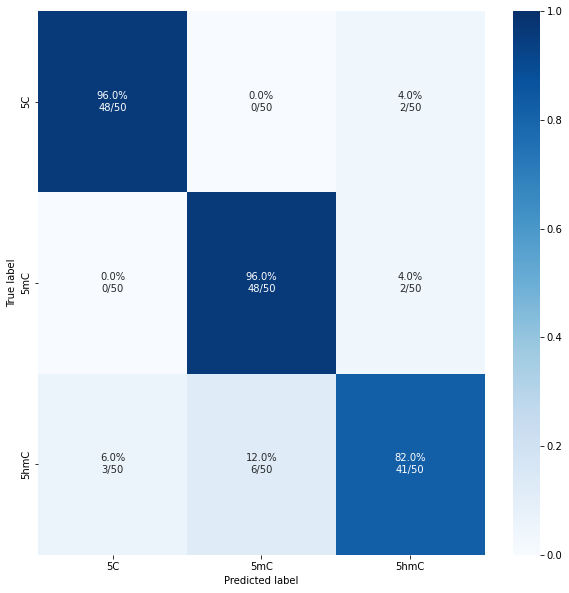

In [19]:
##Save the confusion matrix and plotting
output_path='/pod/2/li-lab/Ziwei/Nanopore/daily/2021-12-06/result'

label = ['5C', '5mC', '5hmC']    
plot_cm(y_true, y_pred, os.path.join(output_path, "rf.GridSearch.confusion_matrix.png"), label = label, figsize=(10,10))

print('f1_macro for three-way maximum:',f1_score(y_true, y_pred, average='macro'))